# Đáp Án - Bài Tập Xây Dựng Mô Hình Decision Tree: Dự đoán giá xe (CarDekho)

## Giới thiệu

Notebook này cung cấp lời giải chi tiết cho bài tập xây dựng mô hình Decision Tree để dự đoán giá bán của xe ô tô cũ. Chúng ta sẽ tiến hành tiền xử lý dữ liệu, xây dựng mô hình Decision Tree Regression, đánh giá mô hình và thực hiện tối ưu hóa hyperparameter.


### Nhập các thư viện và bộ dữ liệu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Đọc dữ liệu
df_original = pd.read_csv('cardekho_data.csv')
# Hiển thị 5 dòng đầu tiên
df_original.head()


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


### Khám phá bộ dữ liệu

In [3]:
# Kiểu dữ liệu và kích thước
df_original.info()
print("Kích thước dữ liệu:", df_original.shape)

# Thống kê mô tả cho các biến số
df_original.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB
Kích thước dữ liệu: (301, 9)


,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


### Các nhóm của các biến phân loại

In [4]:
# Các giá trị duy nhất của biến phân loại
for col in ['Fuel_Type','Seller_Type','Transmission','Owner']:
    print(f"{col}:", df_original[col].unique())


Fuel_Type: ['Petrol' 'Diesel' 'CNG']
Seller_Type: ['Dealer' 'Individual']
Transmission: ['Manual' 'Automatic']
Owner: [0 1 3]


### Phân bố biến mục tiêu `Selling_Price`

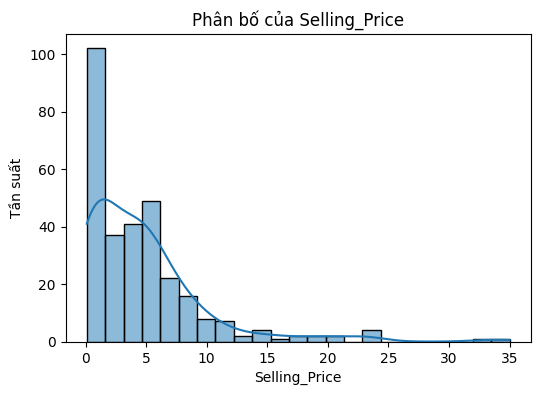

In [5]:
# Thống kê mô tả và biểu đồ phân bố
df_original['Selling_Price'].describe()

plt.figure(figsize=(6,4))
sns.histplot(df_original['Selling_Price'], kde=True)
plt.title('Phân bố của Selling_Price')
plt.xlabel('Selling_Price')
plt.ylabel('Tần suất')
plt.show()


**Nhận xét:** Biến `Selling_Price` có phân bố lệch phải; phần lớn xe có giá bán thấp (dưới 5 đơn vị), trong khi chỉ có một số ít xe có giá cao hơn. Điều này có thể ảnh hưởng tới việc huấn luyện mô hình, vì mô hình cần dự đoán tốt cả những giá trị hiếm gặp.

### Kiểm tra dữ liệu trống

In [6]:
# Số lượng giá trị trống trong từng cột
missing_counts = df_original.isnull().sum()
missing_counts


Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

**Trả lời:** Kiểm tra và xử lý dữ liệu trống là cần thiết vì các mô hình học máy không thể xử lý trực tiếp các giá trị thiếu. Nếu bỏ qua, mô hình có thể đưa ra dự đoán sai hoặc phát sinh lỗi khi huấn luyện. Ta cần xem xét loại bỏ hoặc điền giá trị thay thế cho các giá trị trống để dữ liệu nhất quán.

### Tạo biến tuổi xe và xử lý cột `Car_Name`

In [7]:
df = df_original.copy()
# Tạo cột Age
df['Age'] = 2025 - df['Year']
# Loại bỏ cột Year và Car_Name
df = df.drop(['Year','Car_Name'], axis=1)

# One-hot encode các biến phân loại
categorical_cols = ['Fuel_Type','Seller_Type','Transmission','Owner']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Kiểm tra lại kích thước dữ liệu và kiểu dữ liệu
print('Kích thước sau xử lý:', df.shape)
print(df.dtypes)


Kích thước sau xử lý: (301, 10)
Selling_Price             float64
Present_Price             float64
Kms_Driven                  int64
Age                         int64
Fuel_Type_Diesel             bool
Fuel_Type_Petrol             bool
Seller_Type_Individual       bool
Transmission_Manual          bool
Owner_1                      bool
Owner_3                      bool
dtype: object


### Chia dữ liệu train và test

In [13]:
# Tách biến đầu vào X và biến mục tiêu y
X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

# Chia dữ liệu (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)

print('Kích thước tập train:', X_train.shape)
print('Kích thước tập test:', X_test.shape)
print(y_train.shape)


Kích thước tập train: (225, 9)
Kích thước tập test: (76, 9)
(225,)


## Xây dựng mô hình Decision Tree

In [9]:
# Khởi tạo và huấn luyện mô hình
model_dt = DecisionTreeRegressor(random_state=8)
model_dt.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred_dt = model_dt.predict(X_test)

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_test, y_pred_dt)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_dt)
r2 = r2_score(y_test, y_pred_dt)

print('MSE:', round(mse,4))
print('RMSE:', round(rmse,4))
print('MAE:', round(mae,4))
print('R^2:', round(r2,4))


MSE: 2.2509
RMSE: 1.5003
MAE: 0.7668
R^2: 0.9159


**Trả lời:** Mô hình Decision Tree có ưu điểm là dễ diễn giải, không yêu cầu chuẩn hóa dữ liệu và có khả năng nắm bắt các quan hệ phi tuyến giữa biến đầu vào và biến mục tiêu. Điều này phù hợp với bài toán dự đoán giá xe, nơi mối quan hệ giữa các đặc trưng và giá bán có thể rất phi tuyến.

### Đánh giá mô hình và lựa chọn chỉ số phù hợp

**Trả lời:** RMSE và MAE đều đo sai số trên cùng đơn vị với biến mục tiêu, giúp chúng ta dễ dàng hiểu mức chênh lệch trung bình giữa giá trị dự đoán và giá trị thực tế. RMSE phạt nặng các sai số lớn hơn, còn MAE coi trọng tất cả sai số như nhau. R² cho biết tỷ lệ biến động của biến mục tiêu được giải thích bởi mô hình. Tuỳ mục đích, RMSE hoặc MAE thường được dùng để so sánh chất lượng mô hình.

### Trực quan hóa cây quyết định

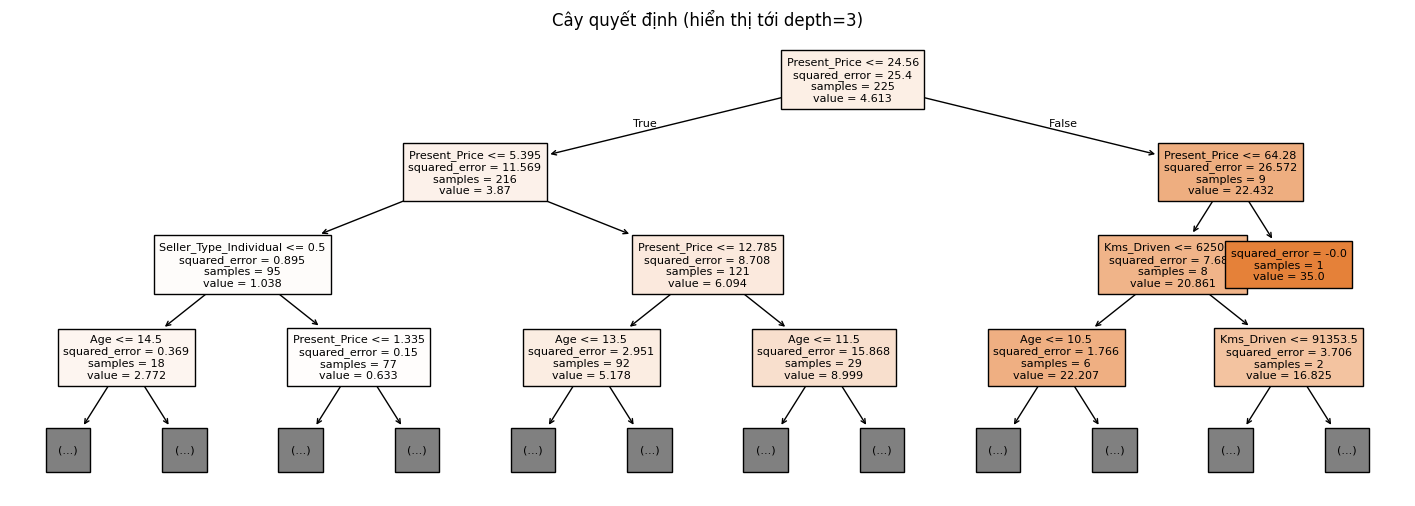

In [10]:
plt.figure(figsize=(18,6))
plot_tree(model_dt, feature_names=X.columns, filled=True, max_depth=3, fontsize=8)
plt.title('Cây quyết định (hiển thị tới depth=3)')
plt.show()


## Độ quan trọng của các biến

                  Feature  Importance
0           Present_Price    0.872512
2                     Age    0.093833
1              Kms_Driven    0.019805
5  Seller_Type_Individual    0.011776
3        Fuel_Type_Diesel    0.001603
6     Transmission_Manual    0.000392
4        Fuel_Type_Petrol    0.000040
7                 Owner_1    0.000038
8                 Owner_3    0.000000


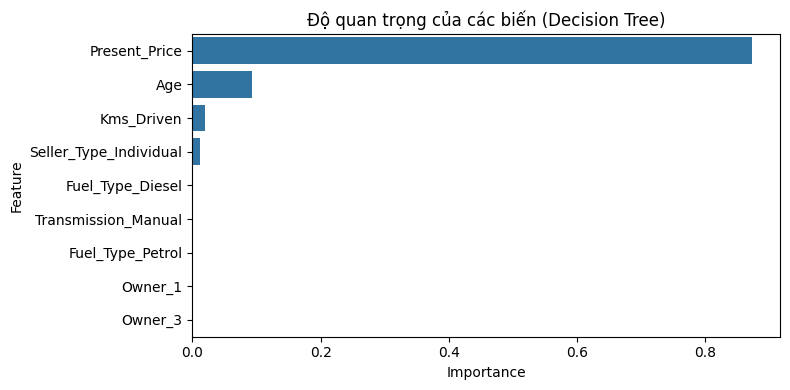

In [11]:
# Tính toán độ quan trọng
importances = model_dt.feature_importances_
features = X.columns

imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
imp_df = imp_df.sort_values('Importance', ascending=False)
print(imp_df)

# Vẽ biểu đồ
plt.figure(figsize=(8,4))
sns.barplot(x='Importance', y='Feature', data=imp_df)
plt.title('Độ quan trọng của các biến (Decision Tree)')
plt.tight_layout()
plt.show()


**Trả lời:** Biến `Present_Price` có ảnh hưởng lớn nhất tới giá bán, theo sau là `Age` (tuổi xe) và `Kms_Driven`. Điều này hợp lý vì giá xe mới và thời gian sử dụng là những yếu tố chính quyết định giá bán lại của xe.

## Tune hyperparameter bằng GridSearchCV

In [12]:
# Định nghĩa lưới tham số
param_grid = {
    'max_depth': [None, 2, 3, 4, 5, 6, 7],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Thiết lập GridSearchCV
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=8), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Huấn luyện
grid_dt.fit(X_train, y_train)

# Mô hình tốt nhất
best_dt = grid_dt.best_estimator_
print('Best parameters:', grid_dt.best_params_)

# Dự đoán và đánh giá
y_pred_best = best_dt.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print('MSE:', round(mse_best,4))
print('RMSE:', round(rmse_best,4))
print('MAE:', round(mae_best,4))
print('R^2:', round(r2_best,4))


Best parameters: {'max_depth': 7, 'min_samples_leaf': 1}
MSE: 2.7897
RMSE: 1.6702
MAE: 0.8826
R^2: 0.8957


**Trả lời:** Trong trường hợp này, việc tune hyperparameter không giúp cải thiện mô hình đáng kể (R² giảm nhẹ). Lý do có thể do bộ dữ liệu nhỏ và cây quyết định cơ bản đã đủ phức tạp để mô tả quan hệ giữa các biến. Việc thử nhiều tham số đôi khi dẫn tới mô hình quá phức tạp hoặc quá đơn giản so với dữ liệu.